In [1]:
## Not sure what I'm doing

import numpy as np
import pandas as pd
import pickle
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import statistics

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from utils import flatten

## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'
runDir = 'expectedReadCutoffEvaluation_v0/'
plotDir = f'{dataDir}{runDir}Plots_1kChains_600_750_3/'
outDir = f'{dataDir}{runDir}dfs_1kChains_600_750_3/'

In [2]:
numFiles = 1000
with open(f'{dataDir}makeHyperGraphDict/hyperEdges_3_600_750_{numFiles}_chains.pkl','rb') as f:
    hpEdges = pickle.load(f)

numEdges = np.loadtxt(f'{dataDir}makeHyperGraphDict/numEdges_3_600_750_{numFiles}_chains.txt')

In [3]:
hpKeys = [k for k in hpEdges.keys()]
hpKeys_split = [k.split("_") for k in hpEdges.keys()]
keyCard = [len(item) for item in hpKeys_split]

## Functions

In [4]:
def getPairwiseDist(combination):
    """Given a two-way interaction, find dist between them"""
    ends = [int(combination[i].split(":")[1]) for i in [0,1]]
    diff = (ends[1] - ends[0]) / 5
    return(diff)

def getNWayMeanDistPerSubset(comb):
    """Get the mean pairwise distance given a
    high cardinality read"""
    twoWays = list(combinations(comb,2))
    twoWayDist = [getPairwiseDist(c) for c in twoWays]
    meanDist = round(statistics.mean(twoWayDist))
    return(meanDist)

def makeNWayDict(ix,hpEdges,hpKeys_split,n):
    """For a high cardinality read, make a dictionary
    that outputs the frequency and mean distance for subsets
    of cardinality n"""
    splitKey = hpKeys_split[ix]
    combs = list(combinations(splitKey,n))
    subsetDict = defaultdict(int)
    for comb in combs:
        subsetEdge = '_'.join(map(str, comb))
        subsetEdgeReads = hpEdges[subsetEdge]
        meanDist = getNWayMeanDistPerSubset(comb)
        subsetDict[meanDist] = subsetEdgeReads
    return(subsetDict)

def getProbabilitiesByDist(mainDict):
    """Get probabilities of reads occurring by mean dist to
    obtain the expected probability distribution from the data"""
    totalReadsForCard = sum(mainDict.values())
    normalized_values = [value / totalReadsForCard for value in mainDict.values()]
    return(normalized_values)

def getNWayProbsPerCard(card,hpEdges,keyCard,hpKeys_split,n,toPlot):
    """Get distance-stratified expected probability distribution for high
    cardinality reads and their subsets of cardinality n"""
    ixList = [index for index,element in enumerate(keyCard) if element == card]
    mainDict = defaultdict(int)

    for ix in ixList:
        nWayDict = makeNWayDict(ix,hpEdges,hpKeys_split,n)
        for key in nWayDict.keys():
            mainDict[key] += nWayDict[key]

    normalized_values = getProbabilitiesByDist(mainDict)
    if toPlot is True:
        plotReadFreqsPerCard(mainDict,normalized_values,card,n)
    
    probabilityDict = {list(mainDict.keys())[ix]:normalized_values[ix] for ix in range(len(normalized_values))}
    return(probabilityDict)

def makeAllReferenceHashDicts(keyCard,hpEdges,hpKeys_split):
    """For all available cards, create look up table of probability of
    seeing all possible subsets as a function of mean distances
    between subsets"""
    probHash = defaultdict(dict)

    for card in range(max(keyCard),2,-1):
        print("Calculating for card=",card)
        ixList = [index for index,element in enumerate(keyCard) if element == card]
        print("There are ",len(ixList),"reads")
        for n in range(2,card):
            print(f"Creating a probability hash for {n}-way subsets")
            hashID = f'{card}sub{n}'
            probHash[hashID] = getNWayProbsPerCard(card,hpEdges,keyCard,hpKeys_split,n,True)
    return(probHash)

def plotReadFreqsPerCard(mainDict,normalized_values,card,n):
    """Takes in a generated dictionary and plots the
    read frequency as well as probabilities (first 20) by the
    distance"""

    # Step 1: Plot a barplot with dictionary keys on the x-axis and values on the y-axis
    sns.barplot(x=list(mainDict.keys()), y=list(mainDict.values()),color = "grey")
    plt.title(f"Read frequency of {n}-way subsets for Card={card}")
    plt.xlabel(f"Mean distance between {n}-way interactions")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90,fontsize=5)
    plt.savefig(f'{plotDir}DistStratProbs_Card{card}sub{n}.png',bbox_inches = 'tight',facecolor = "white")
    #plt.show()

    # Step 2: Plot the same barplot with the ratio of each value to the total
    sns.barplot(x=list(mainDict.keys()), y=normalized_values,color = "grey")
    plt.title(f"Probability of occurrence {n}-way distance for Card={card}")
    plt.xlabel(f"Mean distance between {n}-way interactions")
    plt.ylabel("Probabilities")
    plt.xlim(0,19)
    plt.xticks(rotation=90)
    plt.savefig(f'{plotDir}DistStratProbs_top20_Card{card}sub{n}.png',bbox_inches = 'tight',facecolor = "white")
    #plt.show()
    plt.close()
    return None

def getReadExpectednessStats(card,ix,hpKeys_split,n,expHash,toPlot):
    """Per read, get the observed distribution of n-way contacts
    and calculate similarity to the expected distribution"""
    readDict = makeNWayDict(ix,hpEdges,hpKeys_split,n)
    readPercs = getProbabilitiesByDist(readDict)
    probVals = [expHash[k] for k in readDict.keys()]
    if toPlot is True:
        makeSanityCheckPlotsPerRead(readDict,readPercs,probVals,card,n)
    correlation = np.corrcoef(readPercs, probVals)[0, 1]
    similarity = cosine_similarity(np.array(readPercs).reshape(1,-1), 
                                np.array(probVals).reshape(1,-1))[0,0]
    return(correlation, similarity)

def getStatsPerCard(card,n,probHash,toChoose,toPlot,revised_ixes):
    """Per cardinality, get a subset of reads (for computational
    purposes), calculate the correlation of observed n-way interactions
    to the expected value, and output a list"""
    corrList = []
    cosList = []
    expHash = f'{card}sub{n}'
    for ix in revised_ixes:
        #print(ix)
        corr, cos = getReadExpectednessStats(card,ix,hpKeys_split,n,probHash[expHash],toPlot)
        corrList.append(corr)
        cosList.append(cos)
    return(corrList, cosList)

def statsForAllCardSubsets(card,probHash,toChoose,toPlot,seed):
    """Wrapper for the stats per card. Calculates for all subsets of a card and binds into a df"""
    print("Calculating for card=",card)
    ixList = [index for index,element in enumerate(keyCard) if element == card]
    print("There are ",len(ixList),"reads")
    toChoose = min(toChoose,len(ixList))
    print("Calculating stats for",toChoose,"reads")
    random.seed(seed)
    revised_ixes = random.sample(ixList,toChoose)
    C1 = []
    C2 = []
    for n in range(2,card):
        stats = getStatsPerCard(card,n,probHash,toChoose,toPlot,revised_ixes)
        C1.append(stats[0])
        C2.append(stats[0])
    cN = [str(card)+"Sub"+str(i) for i in range(2,card)]
    df1 = pd.DataFrame(C1).T
    df2 = pd.DataFrame(C2).T
    df1.columns = cN
    df2.columns = cN
    return(df1,df2)

def statsForAllReads(keyCard,probHash,toChoose,toPlot,plotScatter,seed):
    """Wrapper for all reads"""
    for card in range(max(keyCard),3,-1):
        corrStats, cosStats = statsForAllCardSubsets(card,probHash,toChoose,toPlot,seed)
        summaryCos = pd.DataFrame({'mean':cosStats.mean(axis = 1),'sem':cosStats.sem(axis = 1)})
        summaryCorr = pd.DataFrame({'mean':corrStats.mean(axis = 1),'sem':corrStats.sem(axis = 1)})
        if plotScatter is True:
            plotScatterWithErrorBars(summaryCos,"CosineSim",card)
            plotScatterWithErrorBars(summaryCorr,"Pearson Corr",card)
        plotSimilarityHist(summaryCorr['mean'],summaryCos['mean'],card)
        print("Writing output")
        corrStats.to_csv(f'{outDir}/correlation_card{card}.csv',sep = "\t",index=False)
        cosStats.to_csv(f'{outDir}/cosineSim_card{card}.csv',sep = "\t",index=False)
    for card in [3]:
        corrStats, cosStats = statsForAllCardSubsets(card,probHash,toChoose,toPlot,seed)
        plotSimilarityHist(corrStats,cosStats,card)
        print("Writing output")
        corrStats.to_csv(f'{outDir}/correlation_card{card}.csv',sep = "\t",index=False)
        cosStats.to_csv(f'{outDir}/cosineSim_card{card}.csv',sep = "\t",index=False)
    return()

def makeSanityCheckPlotsPerRead(readDict, readPercs, probVals,card,n):
    """For specific reads, plot the observed versus expected distributions
    of two-way interactions along with a fitted spline. Additionally outputs
    the slope (useful only if line) and correlation values"""
    Distances = list(readDict.keys())
    Freqs = readPercs
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(6, 6))

    # Plot 1: Observed w/ spline
    lowess1 = sns.regplot(x=Distances, y=Freqs, lowess=True, ci=None, color='red', ax=axs[0, 0])
    axs[0, 0].set_title(f"Observed w/ spline Card{card}sub{n}")

    # Plot 2: Expected w/ spline
    lowess2 = sns.regplot(x=Distances, y=probVals, lowess=True, ci=None, color='grey', ax=axs[0, 1])
    axs[0, 1].set_title(f"Expected w/ spline Card{card}sub{n}")

    # Calculate smoothed values and slopes
    y_smoothed1 = lowess1.get_lines()[0].get_ydata()
    y_smoothed2 = lowess2.get_lines()[0].get_ydata()

    slope1 = np.gradient(y_smoothed1)
    slope2 = np.gradient(y_smoothed2)

    # Plot 3: Barplot for readPercs
    sns.barplot(x=list(readDict.keys()), y=readPercs, ax=axs[1, 0])
    axs[1, 0].set_title(f"Barplot for readPercs Card{card}sub{n}")

    # Plot 4: Barplot for probVals
    sns.barplot(x=list(readDict.keys()), y=probVals, ax=axs[1, 1])
    axs[1, 1].set_title(f"Barplot for probVals Card{card}sub{n}")

    correlation = np.corrcoef(readPercs, probVals)[0, 1]
    similarity = cosine_similarity(np.array(readPercs).reshape(1,-1), 
                  np.array(probVals).reshape(1,-1))[0,0]
    
    # Print the slopes
    print("Comparing -------------")
    print(f"Slope for observed: {slope1.mean()}")
    print(f"Slope for expected: {slope2.mean()}")
    print(f"Correlation: {correlation}")
    print(f"Cosine similarity: {similarity}")

    # Adjust layout and show the subplots
    plt.tight_layout()
    plt.show()
    plt.close()
    return None

def plotSimilarityHist(corrList,cosList,card):
    """Given distribution for a cardinality, plot the correlation
    and cosine similarity values so that we can settle on a heuristic"""
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot 1: Pearson correlation histogram
    axs[0].hist(corrList, color='blue', alpha=0.7, width=0.3, bins=201)
    axs[0].set_xlim(-1, 1.01)
    axs[0].set_title(f"Mean pearson correlation for card={card}")

    # Plot 2: Cosine similarity histogram
    axs[1].hist(cosList, color='green', alpha=0.7, width=0.3, bins=101)
    axs[1].set_xlim(0, 1.01)
    axs[1].set_title(f"Mean cosine similarity for card={card}")
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'{plotDir}/Histogram_Card{card}.png',bbox_inches = 'tight',facecolor = "white")
    #plt.show()
    plt.close()
    return None


def plotScatterWithErrorBars(summaryDF,metric,card):
    """Given summary stats for a certain number of reads, plot scatter plot with error bars 
    representing change over all subsets"""
    sortedSumm = summaryDF.sort_values(by='mean')
    x = [i+1 for i in range(summaryDF.shape[0])] # Use the index as x-axis
    y = sortedSumm['mean']
    error = sortedSumm['sem']

    plt.scatter(x, y, label=f'mean {metric}', marker='o')
    plt.errorbar(x, y, yerr=error, linestyle='None', color='grey', capsize=3)
    plt.xlabel('ReadID')
    plt.ylabel(f'mean {metric}')
    plt.ylim(-1,1)
    plt.title(f'Distribution for card={card}')
    plt.legend()
    plt.savefig(f'{plotDir}/ScatterPlot_{metric}_Card{card}.png',bbox_inches = 'tight',facecolor = "white")
    #plt.show()
    plt.close()
    return None



## Start computation

In [5]:
# D5sub3 = getNWayProbsPerCard(5,hpEdges,keyCard,hpKeys_split,3,False)
# D8sub5 = getNWayProbsPerCard(8,hpEdges,keyCard,hpKeys_split,5,False)
# D8sub7 = getNWayProbsPerCard(8,hpEdges,keyCard,hpKeys_split,7,False)
# D7sub5 = getNWayProbsPerCard(7,hpEdges,keyCard,hpKeys_split,5,False)
D9sub2 = getNWayProbsPerCard(9,hpEdges,keyCard,hpKeys_split,2,False)

In [26]:
import json
probHashOutName = f'{outDir}probHash_1kChains_3_600_750.json'
with open(probHashOutName,'r') as file:
    tmpHash = json.load(file)
    probHash = {key: {int(k): v for k, v in value.items()} for key, value in tmpHash.items()}

In [28]:
D9sub2[3]
probHash['9sub2'][3]

0.056174004932918235

In [9]:
## test
print(len(hpKeys))
ix = 440510
print(hpKeys[440510])
readDict = makeNWayDict(440510,hpEdges,hpKeys_split,4)
print(readDict)
# probVals = [probHash['9sub2'][k] for k in readDict.keys()]
probVals = [D9sub2[k] for k in readDict.keys()]

print(probVals)


619813
Bin0:4_Bin15:19_Bin30:34_Bin35:39_Bin75:79_Bin80:84_Bin110:114_Bin115:119_Bin490:494
defaultdict(<class 'int'>, {4: 2975, 8: 171, 12: 91, 50: 1, 9: 112, 10: 133, 13: 85, 14: 298, 51: 1, 15: 325, 52: 14, 11: 1260, 49: 13, 6: 1524, 7: 140, 48: 1, 47: 3, 46: 10, 5: 697, 42: 3, 43: 7, 41: 5})


KeyError: 50

In [154]:
warnings.filterwarnings('ignore')

corrList, cosList = getStatsPerCard(5,3,4000,False,1)
len(corrList)

Calculating for card= 5
There are  1087780 reads
Calculating stats for 4000 reads


4000

In [150]:
cosSer = pd.Series(cosList)
summary = cosSer.describe()
summary

count    4000.000000
mean        0.845613
std         0.172810
min         0.118564
25%         0.775069
50%         0.906070
75%         0.978415
max         0.999994
dtype: float64

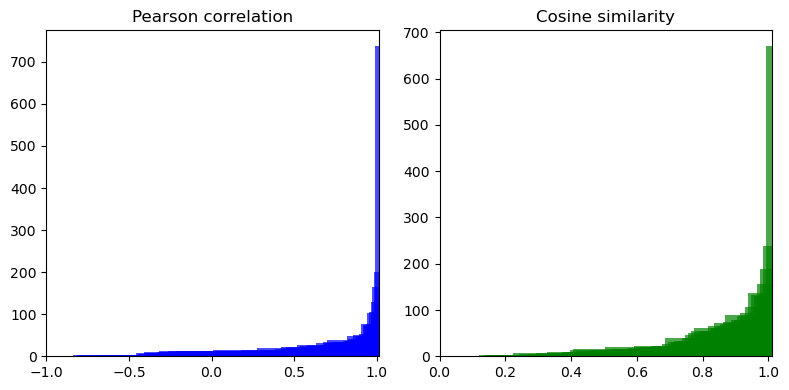

In [151]:
plotSimilarityHist(corrList,cosList)

## Run comprehensively
- Compile all the probablity dictionaries of card + subsets
- Run the correlation for all cards and subsets
- Track the correlation value for the same read across multiple subsets

In [7]:
probHash = makeAllReferenceHashDicts(keyCard,hpEdges,hpKeys_split)

Calculating for card= 9
There are  4 reads
Creating a probability hash for 2-way subsets
Creating a probability hash for 3-way subsets
Creating a probability hash for 4-way subsets
Creating a probability hash for 5-way subsets
Creating a probability hash for 6-way subsets
Creating a probability hash for 7-way subsets
Creating a probability hash for 8-way subsets
Calculating for card= 8
There are  182 reads
Creating a probability hash for 2-way subsets
Creating a probability hash for 3-way subsets
Creating a probability hash for 4-way subsets
Creating a probability hash for 5-way subsets
Creating a probability hash for 6-way subsets
Creating a probability hash for 7-way subsets
Calculating for card= 7
There are  3464 reads
Creating a probability hash for 2-way subsets
Creating a probability hash for 3-way subsets
Creating a probability hash for 4-way subsets
Creating a probability hash for 5-way subsets
Creating a probability hash for 6-way subsets
Calculating for card= 6
There are  350

In [26]:
warnings.filterwarnings('ignore')
statsForAllReads(keyCard,probHash,5000,False,False,1)

Calculating for card= 9
There are  4 reads
Calculating stats for 4 reads
Writing output
Calculating for card= 8
There are  182 reads
Calculating stats for 182 reads
Writing output
Calculating for card= 7
There are  3464 reads
Calculating stats for 3464 reads
Writing output
Calculating for card= 6
There are  35016 reads
Calculating stats for 5000 reads
Writing output
Calculating for card= 5
There are  173475 reads
Calculating stats for 5000 reads
Writing output
Calculating for card= 4
There are  295052 reads
Calculating stats for 5000 reads
Writing output
Calculating for card= 3
There are  107671 reads
Calculating stats for 5000 reads
Writing output


()